In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample
from sklearn.linear_model import Ridge, ElasticNet

import naplib as nl
from naplib.visualization import imSTRF

import auditory_cortex.helpers as helpers
import auditory_cortex.analysis.config as config
import auditory_cortex.analysis.analysis as analysis

In [2]:
reg_obj = helpers.get_regression_obj(load_features=False)

loading weights from: /depot/jgmakin/data/auditory_cortex/pretrained_weights/w2l_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt
Regression object...
Creating regression obj for: 'wav2letter_modified'


In [3]:
spikes = reg_obj.load_spikes(bin_width=10, numpy=True)

In [43]:
reg_obj.raw_spikes[12].shape

(137, 64)

### using STRF class....

In [2]:
strf = analysis.STRF()

loading weights from: /depot/jgmakin/data/auditory_cortex/pretrained_weights/w2l_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt
Regression object...
Creating regression obj for: 'wav2letter_modified'


In [4]:
strf_model = strf.fit()

  0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

### STRF using 'naplib'

In [44]:
aud = reg_obj.dataset.audio(sent=12)

In [13]:
sent_ids = [12,13,18,10]
sent_ids = [12, 13]

In [14]:
fs = reg_obj.dataset.fs
spikes = reg_obj.load_spikes(bin_width=10, numpy=True)

In [27]:

spect_list = []
spikes_list = []
for sent in sent_ids:
    aud = reg_obj.dataset.audio(sent)
    # read spikes for the sent id, as (time, channel)
    spikes = reg_obj.raw_spikes[sent].astype(np.float32)
    # get spectrogram for the audio inputs, as (time, freq) 
    spect = nl.features.auditory_spectrogram(aud, fs)
    # resample spect to get same # number of time samples as in spikes..
    spect = resample(spect, spikes.shape[0], axis=0)

    # spect has 128 channels at this point, we can reduce the channels 
    # for easy training, following examples lets reduce to 32 for now...
    spect_32 = resample(spect, 32, axis=1)
    spect_list.append(spect_32)
    spikes_list.append(np.expand_dims(spikes[:,32], axis=1))
    print(spect_32.shape)
    print(spikes.shape)





(137, 32)
(137, 64)
(180, 32)
(180, 64)


In [83]:
spect_list[0].shape

(137, 32)

In [84]:
spikes_list[0].shape

(137, 1)

In [56]:
spects = np.concatenate(spect_list, axis=0)
spikess = np.concatenate(spikes_list, axis=0)

In [57]:
type(spikess)

numpy.ndarray

In [58]:
spikess.shape

(317, 64)

In [74]:
out = np.expand_dims(spikess[:,32], axis=1)
out = np.expand_dims(out, axis=0)
inp = np.expand_dims(spects, axis=0)

In [19]:
print(inp.shape)
print(out.shape)

NameError: name 'inp' is not defined

In [20]:
spikes_list[0].shape

(137, 1)

In [33]:
spikes_list[1].shape

(180, 1)

In [29]:
spikessssss = nl.preprocessing.normalize(spikes_list)

TypeError: data found is not either np.ndarray, or list or arrays, but found <class 'str'>

In [31]:
type(spikes_list)

list

In [85]:
n_workers = 1

tmin = 0 # receptive field begins at time=0
tmax = 0.3 # receptive field ends at a lag of 0.4 seconds
sfreq = 100 # sampling frequency of data

# setting show_progress=False would disable the progress bar
strf_model = nl.encoding.TRF(tmin, tmax, sfreq, estimator=Ridge(10),n_jobs=n_workers ,show_progress=True)

# strf_model.fit(X=spects, y=spikess[:,32])
# strf_model.fit(X=inp, y=out)
strf_model.fit(X=spect_list, y=spikes_list)


  0%|          | 0/1 [00:00<?, ?it/s]

(180, 32)

In [8]:
fs = reg_obj.dataset.fs

In [5]:
aud.shape

(21914,)

In [9]:
spect = nl.features.auditory_spectrogram(aud, fs)

In [10]:
spect.shape

(172, 128)

In [11]:
reg_obj.dataset.duration(12)

1.369625

In [12]:
1.369*100

136.9

### Example code from naplib page

In [24]:
sent_id = 1
data_list = []
for sent_id in range(1,499):
    sound = np.expand_dims(reg_obj.dataset.audio(sent_id), axis=1)
    soundf = 16000
    resp = reg_obj.raw_spikes[sent_id]
    trial = {'name': sent_id, 'aud': sound, 'soundf': soundf, 'resp': resp}
    data_list.append(trial)

In [28]:
mydata = nl.Data(data=data_list)

In [33]:
mydata['resp']

AttributeError: 'list' object has no attribute 'shape'

In [30]:
data = mydata
# This data contains the fields 'aud' and 'resp', which give the stimulus and neural responses
print(f"aud stimulus shape for first trial : {data[0]['aud'].shape}")
print(f"response shape for first trial : {data[0]['resp'].shape}")

# first, we normalize the responses
data['resp'] = nl.preprocessing.normalize(data=data, field='resp')

# get auditory spectrogram for each stimulus sound
data['spec'] = [nl.features.auditory_spectrogram(trial['sound'], 11025) for trial in data]

# make sure the spectrogram is the exact same size as the responses
data['spec'] = [resample(trial['spec'], trial['resp'].shape[0]) for trial in data]

# Since the spectrogram is 128-channels, which is very large, we downsample it
print(f"before resampling: {data['spec'][0].shape}")

resample_kwargs = {'num': 32, 'axis': 1}
data['spec_32'] = nl.array_ops.concat_apply(data['spec'], resample, function_kwargs=resample_kwargs)

print(f"after resampling:  {data['spec_32'][0].shape}")

aud stimulus shape for first trial : (29082, 1)
response shape for first trial : (91, 64)


TypeError: data found is not either np.ndarray, or list or arrays, but found <class 'list'>

In [77]:
data[0]['spect'].shape

NameError: name 'data' is not defined

In [6]:
type(reg_obj.raw_features[0])

dict

In [10]:
type(reg_obj.raw_spikes)

dict

In [20]:
reg_obj.raw_spikes[1]

(91, 64)

In [11]:
reg_obj.raw_spikes.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [8]:
type(reg_obj.raw_spikes[0])

AttributeError: 'transformer_regression' object has no attribute 'raw_spikes'

In [7]:
reg_obj.raw_features[0].keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 22

In [ ]:
data = nl.io.load_speech_task_data()

### set up the data

In [9]:
data = nl.io.load_speech_task_data()

# This data contains the fields 'aud' and 'resp', which give the stimulus and neural responses
print(f"aud stimulus shape for first trial : {data[0]['aud'].shape}")
print(f"response shape for first trial : {data[0]['resp'].shape}")

# first, we normalize the responses
data['resp'] = nl.preprocessing.normalize(data=data, field='resp')

# get auditory spectrogram for each stimulus sound
data['spec'] = [nl.features.auditory_spectrogram(trial['sound'], 11025) for trial in data]

# make sure the spectrogram is the exact same size as the responses
data['spec'] = [resample(trial['spec'], trial['resp'].shape[0]) for trial in data]

# Since the spectrogram is 128-channels, which is very large, we downsample it
print(f"before resampling: {data['spec'][0].shape}")

resample_kwargs = {'num': 32, 'axis': 1}
data['spec_32'] = nl.array_ops.concat_apply(data['spec'], resample, function_kwargs=resample_kwargs)

print(f"after resampling:  {data['spec_32'][0].shape}")

aud stimulus shape for first trial : (6197, 128)
response shape for first trial : (6197, 10)


before resampling: (6197, 128)
after resampling:  (6197, 32)


In [10]:
data = nl.io.load_speech_task_data()

In [24]:
data[1]['aud'].shape

(5203, 128)

In [11]:
np.logspace(-2,5, 8)

array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05])

In [13]:
first = np.zeros((10,6))
second = np.zeros((2,2))

In [14]:
np_dict = {'first': first,
           'second': second}

In [18]:
np.save('./test.npv', np_dict)

In [20]:
ff = np.load('./test.npv.npy', allow_pickle=True)

In [21]:
ff

array({'first': array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]]), 'second': array([[0., 0.],
       [0., 0.]])}, dtype=object)

In [17]:
data[0].keys()

dict_keys(['name', 'sound', 'soundf', 'dataf', 'duration', 'befaft', 'resp', 'aud', 'script', 'chname'])

In [23]:
data[1]['soundf']

11025.0

In [22]:
data[1]['dataf']

99.99999999999999

In [21]:
data[1]['duration']

52.029666666666685

In [27]:
data[1]['resp'].shape

(5203, 10)

In [3]:
tmin = 0 # receptive field begins at time=0
tmax = 0.3 # receptive field ends at a lag of 0.4 seconds
sfreq = 100 # sampling frequency of data

# setting show_progress=False would disable the progress bar
strf_model = nl.encoding.TRF(tmin, tmax, sfreq, estimator=Ridge(10), show_progress=True)

# leave out 1 trial for testing
data_train = data[:-1]
data_test = data[-1:]

strf_model.fit(data=data_train, X='spec_32', y='resp')

  0%|          | 0/10 [00:00<?, ?it/s]

TRF(estimator=Ridge(alpha=10), sfreq=100.0, tmax=0.3, tmin=0)

### fit the STRF using Elastic net

In [4]:
# define the estimator to be used in this TRF model
estimator = ElasticNet(l1_ratio=0.01)

strf_model_2 = nl.encoding.TRF(tmin, tmax, sfreq, estimator=estimator)
strf_model_2.fit(data=data_train, X='spec_32', y='resp')

  0%|          | 0/10 [00:00<?, ?it/s]

TRF(estimator=ElasticNet(l1_ratio=0.01), sfreq=100.0, tmax=0.3, tmin=0)

### analyze the STRF weights

STRF shape (num_outputs, frequency, lag) = (10, 32, 31)


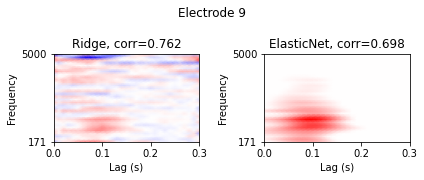

In [6]:
# compute model scores
scores = strf_model.score(data=data_test, X='spec_32', y='resp')
scores_2 = strf_model_2.score(data=data_test, X='spec_32', y='resp')

# we can access the STRF weights through the .coef_ attribute of the model
coef_ridge = strf_model.coef_
coef_elastic = strf_model_2.coef_

print(f'STRF shape (num_outputs, frequency, lag) = {coef_ridge.shape}')

# Now, visualize the STRF weights for the last electrode and for each model

freqs = [171, 5000]

elec = 9
model_1_coef, model_2_coef, score_model_1, score_model_2 = coef_ridge[elec], coef_elastic[elec], scores[elec], scores_2[elec]

fig, axes = plt.subplots(1,2,figsize=(6,2.5))
imSTRF(model_1_coef, tmin=tmin, tmax=tmax, freqs=freqs, ax=axes[0])
axes[0].set_title('Ridge, corr={:2.3f}'.format(score_model_1))
imSTRF(model_2_coef, tmin=tmin, tmax=tmax, freqs=freqs, ax=axes[1])
axes[1].set_title('ElasticNet, corr={:2.3f}'.format(score_model_2))
fig.suptitle(f'Electrode {elec}')
fig.tight_layout()
plt.show()

### anaylyze the STRF score

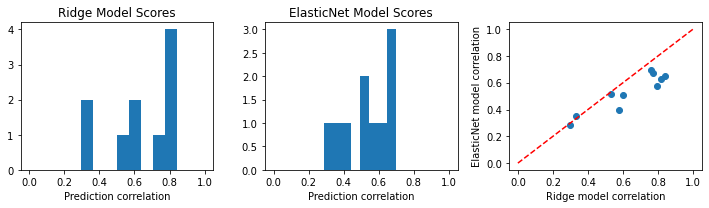

In [7]:
# compare the scores from each model's predictions

fig, axes = plt.subplots(1,3,figsize=(10,3), sharex=True)
axes[0].hist(scores, 8)
axes[0].set_xlabel('Prediction correlation')
axes[0].set_title('Ridge Model Scores')
axes[1].hist(scores_2, 8)
axes[1].set_xlabel('Prediction correlation')
axes[1].set_title('ElasticNet Model Scores')
axes[2].scatter(scores, scores_2)
axes[2].set_xlabel('Ridge model correlation')
axes[2].set_ylabel('ElasticNet model correlation')
axes[2].plot([0,1],[0,1],'r--')
plt.tight_layout()
plt.show()

### analyze the STRF predictions

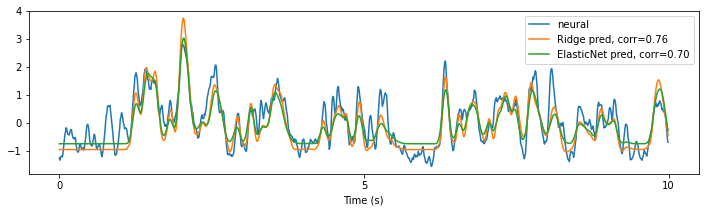

In [8]:
# We see that the two STRF models have nearly identical predictions for most electrodes

predictions = strf_model.predict(data=data_test, X='spec_32') # this is a list of the same length as data_test
predictions_2 = strf_model_2.predict(data=data_test, X='spec_32')

# plot the predictions for the first 10 seconds of the final trial for the last electrode
elec = 9

plt.figure(figsize=(12,3))
plt.plot(data_test['resp'][-1][:1000,elec], label='neural')
plt.plot(predictions[-1][:1000,elec], label='Ridge pred, corr={:2.2f}'.format(scores[elec]))
plt.plot(predictions_2[-1][:1000,elec], label='ElasticNet pred, corr={:2.2f}'.format(scores_2[elec]))
plt.xticks([0, 500, 1000], ['0', '5', '10'])
plt.xlabel('Time (s)')
plt.legend()
plt.show()